In [1]:
import pandas as pd
import numpy as np
import ast

In [2]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Load datasets, merge all useful information into the tracks dataframe

In [3]:
tracks_df = pd.read_csv('../assets/fma_metadata/raw_tracks.csv')
# data needs to be shuffeled it was orderd sequentially 
tracks_df = tracks_df.sample(frac=1, random_state=42)
tracks_df = tracks_df[pd.notnull(tracks_df['track_genres'])]
albums_df = pd.read_csv('../assets/fma_metadata/raw_albums.csv')[['album_id', 'album_type']]
tracks_df = tracks_df.merge(albums_df, on='album_id')
tracks_df = tracks_df.dropna(axis=0, subset=['album_type'])

### Do data wrangling with the dates and some missing categorical features that seem useful

In [4]:
def get_sec(time_str):
    if type(time_str) != type(""): return time_str # not super effecient
    time_list = [*time_str.split(':')]
    if len(time_list)==3:
        return int(time_list[0]) * 3600 + int(time_list[1]) * 60 + int(time_list[2])
        # h, m, s
    else: 
        return int(time_list[0]) * 60 + int(time_list[1])
        # m, s
    
def get_genres(value):
    genre_ids = []
    # evaluates the string as python code. it's a dict.
    fixed = ast.literal_eval(value)
    # just return the first genre listed and predict with that
    return int(fixed[0]['genre_id'])

l = []
for i, val in enumerate(tracks_df['track_genres']):
    l.append(get_genres(val))

In [5]:
tracks_df['track_date_created_dt'] = pd.to_datetime(tracks_df['track_date_created'], infer_datetime_format=True)
tracks_df['track_date_recorded_dt'] = pd.to_datetime(tracks_df['track_date_recorded'], infer_datetime_format=True)
tracks_df['track_date_recorded'] = tracks_df['track_date_recorded_dt'].values.astype(np.int64) #using_features.drop(['track_date_recorded', 'track_date_created'])
tracks_df['track_date_created']  = tracks_df['track_date_created_dt'].values.astype(np.int64)
tracks_df['track_language_code'] = tracks_df['track_language_code'].fillna('NA')
tracks_df['track_explicit']      = tracks_df['track_explicit'].fillna('NA')

tracks_df['genre_id'] = l
tracks_df = (tracks_df.merge(pd.read_csv('../assets/fma_metadata/genres.csv'), on='genre_id'))
tracks_df = tracks_df.rename({'#tracks' : 'genre_#tracks', 'parent' : 'genre_parent', 'title'  : 'genre_title', 'top_level' : 'genre_top_level'}, axis=1)

### Define the features to train the model on, taking care to exclude features such as track_interest and album_id for their leakage

In [103]:
meta_features = ['artist_name', 'track_title']
# 'album_id',  'artist_id',
features= ['track_bit_rate', 'track_date_created', 'track_date_recorded', 'track_duration',
           'track_instrumental', 'track_language_code', 'track_number', 'genre_id', 'album_type',
           'genre_parent', 'genre_top_level', 'genre_#tracks', 'track_explicit']

In [7]:
tracks_df.head()

track_id  album_id                                      album_title  \
0     57647   10610.0  Live at WFMU with Irene Trudel December 12 2011   
1     57639   10610.0  Live at WFMU with Irene Trudel December 12 2011   
2     57642   10610.0  Live at WFMU with Irene Trudel December 12 2011   
3     57643   10610.0  Live at WFMU with Irene Trudel December 12 2011   
4     57641   10610.0  Live at WFMU with Irene Trudel December 12 2011   

                                           album_url  artist_id  \
0  http://freemusicarchive.org/music/Melaena_Cadi...      12495   
1  http://freemusicarchive.org/music/Melaena_Cadi...      12495   
2  http://freemusicarchive.org/music/Melaena_Cadi...      12495   
3  http://freemusicarchive.org/music/Melaena_Cadi...      12495   
4  http://freemusicarchive.org/music/Melaena_Cadi...      12495   

     artist_name                                        artist_url  \
0  Melaena Cadiz  http://freemusicarchive.org/music/Melaena_Cadiz/   
1  Melaena Cadiz  http://freemusicarchive.org/music/Melaena_Cadiz/   
2  Melaena Cadiz  http://freemusicarchive.org/music/Melaena_Cadiz/   
3  Melaena Cadiz  http://freemusicarchive.org/music/Melaena_Cadiz/   
4  Melaena Cadiz  http://freemusicarchive.org/music/Melaena_Cadiz/   

             artist_website  \
0  http://melaenacadiz.com/   
1  http://melaenacadiz.com/   
2  http://melaenacadiz.com/   
3  http://melaenacadiz.com/   
4  http://melaenacadiz.com/   

                                  license_image_file  \
0  http://i.creativecommons.org/l/by-nc-nd/3.0/us...   
1  http://i.creativecommons.org/l/by-nc-nd/3.0/us...   
2  http://i.creativecommons.org/l/by-nc-nd/3.0/us...   
3  http://i.creativecommons.org/l/by-nc-nd/3.0/us...   
4  http://i.creativecommons.org/l/by-nc-nd/3.0/us...   

                            license_image_file_large  ...         track_title  \
0  http://fma-files.s3.amazonaws.com/resources/im...  ...       Needles River   
1  http://fma-files.s3.amazonaws.com/resources/im...  ...  Rattle the Windows   
2  http://fma-files.s3.amazonaws.com/resources/im...  ...        Falling Down   
3  http://fma-files.s3.amazonaws.com/resources/im...  ...          Holy Night   
4  http://fma-files.s3.amazonaws.com/resources/im...  ...        Clay Pigeons   

                                           track_url     album_type  \
0  http://freemusicarchive.org/music/Melaena_Cadi...  Radio Program   
1  http://freemusicarchive.org/music/Melaena_Cadi...  Radio Program   
2  http://freemusicarchive.org/music/Melaena_Cadi...  Radio Program   
3  http://freemusicarchive.org/music/Melaena_Cadi...  Radio Program   
4  http://freemusicarchive.org/music/Melaena_Cadi...  Radio Program   

  track_date_created_dt  track_date_recorded_dt  genre_id genre_#tracks  \
0   2011-12-15 17:28:47                     NaT        17         12706   
1   2011-12-15 17:28:41                     NaT        17         12706   
2   2011-12-15 17:28:43                     NaT        17         12706   
3   2011-12-15 17:28:45                     NaT        17         12706   
4   2011-12-15 17:28:43                     NaT        17         12706   

  genre_parent genre_title  genre_top_level  
0            0        Folk               17  
1            0        Folk               17  
2            0        Folk               17  
3            0        Folk               17  
4            0        Folk               17  

[5 rows x 47 columns]

In [8]:
tracks_df['track_duration'] =  tracks_df['track_duration'].apply(get_sec)

In [9]:
tracks_df['track_date_created'].head()

0    1323970127000000000
1    1323970121000000000
2    1323970123000000000
3    1323970125000000000
4    1323970123000000000
Name: track_date_created, dtype: int64

### Split into train and test set. Test set is used for the heroku application.

In [10]:
from sklearn.model_selection import train_test_split
target =  'track_listens'
# drop the columns that would leak information
tracks_df 
train, test = train_test_split(tracks_df, test_size=0.15, random_state=42)
train.shape, test.shape

((86079, 47), (15191, 47))

### Define transformer function to help handle any null values and categorical data 

In [11]:
from sklearn.preprocessing import StandardScaler
# todo: update in app, probably by saving the pipeline
transform_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
)
transform_pipeline.fit(train[features])

def my_transform(df):
    return transform_pipeline.transform(df)

#### RandomizedSearchCV to help determine best model parameters

In [12]:
# from sklearn.model_selection import RandomizedSearchCV

# model = RandomForestRegressor(n_estimators=125, n_jobs=-1)

# params = dict(
#     min_impurity_decrease = [0.0, 0.3, 0.6],
# )

# search = RandomizedSearchCV(
#     model,
#     param_distributions=params,
#     cv=4,
#     scoring='neg_mean_squared_error'
    
# )

In [13]:
# search.fit(my_transform(train[features]), train[target])

In [14]:
# search.best_params_

### Fit and run the model, RandomForestRegressor

In [15]:
from sklearn.linear_model import Ridge, LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

using_features = features.copy()

xpipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(n_estimators=125, warm_start=True, min_samples_leaf=2,
                          min_impurity_decrease=0.6, n_jobs=-1, random_state=42)
)

xpipeline.fit(train[features], train[target])
y_pred = cross_val_predict(xpipeline, train[features], train[target], cv=4)

In [99]:
train['y_pred'] = y_pred

In [58]:
y_pred_test = xpipeline.predict(test[using_features])
test['y_pred'] = y_pred_test

print('R2 Square for model, test set', r2_score(test[target], y_pred_test))

R2 Square for model, test set 0.19583005072929327


#### Use the eli5 library to help determine the most important features in the model

In [17]:
from eli5.sklearn import PermutationImportance

# model = xpipeline[-1]
# permuter = PermutationImportance(
#     model,
#     scoring='neg_mean_squared_log_error'
# )

# perm_x = permuter.fit(my_transform(train[features]), train[target])

In [18]:
# import eli5
# eli5.show_weights(
#     perm_x,
#     top=None,
#     feature_names=list(features)
# )

In [19]:
test[ features ].head()

track_bit_rate   track_date_created  track_date_recorded  \
100938        160000.0  1227666054000000000  1136073600000000000   
85586         320000.0  1465989061000000000 -9223372036854775808   
46194         320000.0  1333313553000000000 -9223372036854775808   
84469         320000.0  1482336947000000000 -9223372036854775808   
82453         201629.0  1313585747000000000 -9223372036854775808   

        track_duration  track_instrumental track_language_code  track_number  \
100938             183                   0                  en             5   
85586              298                   0                  NA             2   
46194              119                   0                  NA             4   
84469               26                   1                  NA             0   
82453              205                   0                  NA             4   

        genre_id     album_type  genre_parent  genre_top_level  genre_#tracks  \
100938        37  Single Tracks             4                4             97   
85586         18          Album          1235             1235           5913   
46194         12          Album             0               12          32923   
84469         18          Album          1235             1235           5913   
82453        107          Album          1235             1235           7206   

       track_explicit  
100938             NA  
85586              NA  
46194              NA  
84469              NA  
82453              NA

#### Baseline MAE if you guessed the mean of the train set for track listens

In [20]:
(train[target] - train[target].mean()).abs().mean()

2463.8989517429372

#### MAE and R2 Square for the model on the train and test sets

In [21]:
(train[target] - y_pred).abs().mean()

1480.2985110991417

In [22]:
print('R2 Square for model, train set', r2_score(train[target], y_pred))

R2 Square for model, train set 0.24175290147040873


In [23]:
(test[target] - y_pred_test).abs().mean()

1420.1102857684175

#### Select track set to play to explain for the project

In [59]:
track_id = 122256
track = test[ test['track_id'] == track_id]
track_index = track.index[0]
track.T

68053
track_id                                                             122256
album_id                                                              18517
album_title                                                           BUFET
album_url                 http://freemusicarchive.org/music/VIC_BANG/BUFET/
artist_id                                                             20451
artist_name                                                        VIC BANG
artist_url                      http://freemusicarchive.org/music/VIC_BANG/
artist_website                                https://vicbang.bandcamp.com/
license_image_file        http://i.creativecommons.org/l/by-nc-sa/3.0/us...
license_image_file_large  http://fma-files.s3.amazonaws.com/resources/im...
license_parent_id                                                         5
license_title             Attribution-Noncommercial-Share Alike 3.0 Unit...
license_url               http://creativecommons.org/licenses/by-nc-sa/3...
tags                                                                     []
track_bit_rate                                                       320000
track_comments                                                            0
track_composer                                                          NaN
track_copyright_c                                                       NaN
track_copyright_p                                                       NaN
track_date_created                                      1436274941000000000
track_date_recorded                                    -9223372036854775808
track_disc_number                                                         1
track_duration                                                           44
track_explicit                                                           NA
track_explicit_notes                                                    NaN
track_favorites                                                           0
track_file                music/no_curator/VIC_BANG/BUFET/VIC_BANG_-_07_...
track_genres              [{'genre_id': '38', 'genre_title': 'Experiment...
track_image_file          https://freemusicarchive.org/file/images/track...
track_information                                                       NaN
track_instrumental                                                        0
track_interest                                                         1549
track_language_code                                                      NA
track_listens                                                          1348
track_lyricist                                                          NaN
track_number                                                              7
track_publisher                                                         NaN
track_title                                                  Ente campestre
track_url                 http://freemusicarchive.org/music/VIC_BANG/BUF...
album_type                                                            Album
track_date_created_dt                                   2015-07-07 13:15:41
track_date_recorded_dt                                                  NaT
genre_id                                                                 38
genre_#tracks                                                         38154
genre_parent                                                              0
genre_title                                                    Experimental
genre_top_level                                                          38
y_pred                                                              1168.32

In [25]:
### Look at Shapley output for our selected track

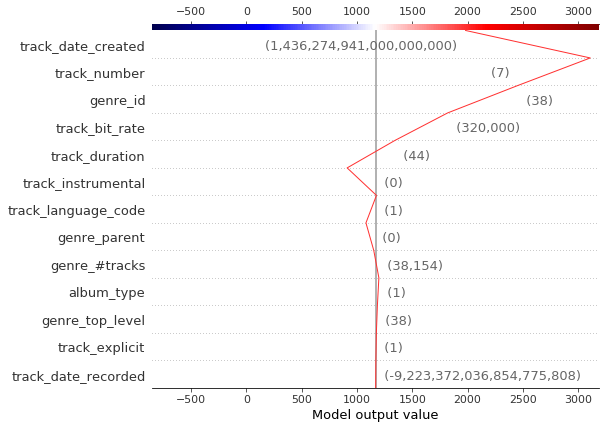

In [63]:
import shap
import matplotlib.pyplot as plt
model = xpipeline[-1]
explainer = shap.TreeExplainer(model)
x = pd.DataFrame(my_transform( track[features] ), columns=features)
shap_values = explainer.shap_values( x )
dp_plot = shap.decision_plot(track['y_pred'].iloc[0], shap_values, x, plot_color='seismic', show=False, return_objects=True)

In [184]:
shap.initjs()
shap.force_plot(, shap_values, x, feature_names=features)
#     expected_value, shap_values, features_display, 
#                 link='logit', matplotlib=True)

In [61]:
track['track_listens'].iloc[0], track['y_pred'].iloc[0]

(1348, 1168.3184507936505)

#### Export csv and model for use in the heroku app

In [34]:
#import pickle
out_df = test.copy()
out_df.to_csv('final.csv')

# pickle.dump(model, open('final-model.pickle', 'wb'))
out_df.head()

track_id  album_id                         album_title  \
100938       834     230.0                      blissblood.com   
85586     139032   20890.0                    Pictures Of Asia   
46194      63100   11439.0  In Sketches Begin Responsibilities   
84469     148129   22086.0        Beat-driven Production Music   
82453      52624    9868.0                  Sunsearcher Spirit   

                                                album_url  artist_id  \
100938  http://freemusicarchive.org/music/Heres_How/bl...        157   
85586   http://freemusicarchive.org/music/TALES/Pictur...      22160   
46194   http://freemusicarchive.org/music/Great_Black_...       9626   
84469   http://freemusicarchive.org/music/Ryan_Cullina...      23539   
82453   http://freemusicarchive.org/music/Sunsearcher/...      11678   

               artist_name                                         artist_url  \
100938          Here's How       http://freemusicarchive.org/music/Heres_How/   
85586                TALES           http://freemusicarchive.org/music/TALES/   
46194   Great Black Waters  http://freemusicarchive.org/music/Great_Black_...   
84469       Ryan Cullinane  http://freemusicarchive.org/music/Ryan_Cullinane/   
82453          Sunsearcher     http://freemusicarchive.org/music/Sunsearcher/   

                                      artist_website  \
100938     http://blissblood.com/index_hereshow.html   
85586                 http://jlhb.free.fr/tales.html   
46194                       www.greatblackwaters.net   
84469                                            NaN   
82453   http://www.jamendo.com/en/artist/Sunsearcher   

                                       license_image_file  \
100938  http://i.creativecommons.org/l/by-nc-sa/3.0/us...   
85586   http://i.creativecommons.org/l/by-nc-nd/4.0/88...   
46194   http://i.creativecommons.org/l/by-nc/3.0/88x31...   
84469   http://i.creativecommons.org/l/by-nc/3.0/88x31...   
82453   http://i.creativecommons.org/l/by-sa/3.0/88x31...   

                                 license_image_file_large  ...  \
100938  http://fma-files.s3.amazonaws.com/resources/im...  ...   
85586   http://fma-files.s3.amazonaws.com/resources/im...  ...   
46194   http://fma-files.s3.amazonaws.com/resources/im...  ...   
84469   http://fma-files.s3.amazonaws.com/resources/im...  ...   
82453   http://fma-files.s3.amazonaws.com/resources/im...  ...   

                                                track_url     album_type  \
100938  http://freemusicarchive.org/music/Heres_How/bl...  Single Tracks   
85586   http://freemusicarchive.org/music/TALES/Pictur...          Album   
46194   http://freemusicarchive.org/music/Great_Black_...          Album   
84469   http://freemusicarchive.org/music/Ryan_Cullina...          Album   
82453   http://freemusicarchive.org/music/Sunsearcher/...          Album   

       track_date_created_dt track_date_recorded_dt  genre_id  genre_#tracks  \
100938   2008-11-26 02:20:54             2006-01-01        37             97   
85586    2016-06-15 11:11:01                    NaT        18           5913   
46194    2012-04-01 20:52:33                    NaT        12          32923   
84469    2016-12-21 16:15:47                    NaT        18           5913   
82453    2011-08-17 12:55:47                    NaT       107           7206   

       genre_parent  genre_title genre_top_level        y_pred  
100938            4  Jazz: Vocal               4   3716.054527  
85586          1235   Soundtrack            1235    958.022952  
46194             0         Rock              12   1226.551837  
84469          1235   Soundtrack            1235   3900.075686  
82453          1235      Ambient            1235  12334.711787  

[5 rows x 48 columns]

In [29]:
out_df['genre_id']

100938      37
85586       18
46194       12
84469       18
82453      107
94843      240
32340        1
17642       15
81682       79
81752      182
89655        8
73043       76
99024       98
99215       88
92293       47
77651       21
39988       12
100014     224
48173       32
55278       10
88140       58
100052     224
84321       18
68341       38
44542       12
67490       38
94990      240
54558       10
96558       31
4193      1235
          ... 
75014       42
48369       32
8447        15
35975       25
36733       27
97770       92
74939       42
10062       15
51207       41
36291       11
77113       21
57283       10
31123        1
20950       15
40976       12
62802       30
44584       12
56449       10
42508       12
41501       12
52074       33
3620        17
96627      137
20277       15
11605       15
7409        15
67360       38
73923       42
77746       21
25721        1
Name: genre_id, Length: 15191, dtype: int64

In [35]:
# pandas didn't like '..'
!mv final.csv '../assets/final.csv'
!mv final-model.pickle '../assets/final-model.pickle'

In [31]:
import plotly.express as px

px.scatter(out_df, x='track_duration', y=target, color='album_type')

#### Conclusion
Comparing the plot above (actual listens), you can see that the model is reluctant to rate anything in the outlier range, but the model seems to match pretty well within the 120k or less range at a glance.

In [32]:
# Give an idea of how the model is doing
# Can see that it's reluctant to rate anything in the outlier range, but the model seems 
#   to match pretty well within the 120k or less range at a glance
px.scatter(out_df, x='track_duration', y='y_pred', color='album_type')

In [33]:
[ print(out_df.iloc[i]['track_title'], '\t', out_df.iloc[i][target],'\t', out_df.iloc[i]['y_pred']) for i in range(10)]

You Showed Me The Way 	 3199 	 3716.054526984127
Eternal Ganga 	 743 	 958.0229523809526
Only Water 	 937 	 1226.5518365505839
Synthetic Pop With Drums 	 5211 	 3900.0756857142883
Ambient Cool 	 15630 	 12334.711787301587
l3go 	 8208 	 7341.334092063493
With You, At Brandy Creek 	 395 	 764.7459576693051
Ai Visto... 	 2971 	 2840.3776
Mascarade 	 4185 	 3948.480247619048
Kantona 	 2011 	 2287.7776634920638


[None, None, None, None, None, None, None, None, None, None]

In [66]:
model.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, min_impurity_decrease=0.6,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1608637542, splitter='best')

In [175]:
from sklearn.tree import export_graphviz

export_graphviz(model.estimators_[0],
                out_file='tree.dot',
                max_depth=4,
                feature_names=features,
                filled=True)

In [176]:
import os
os.system('dot -Tpng tree.dot -o tree.png')

0

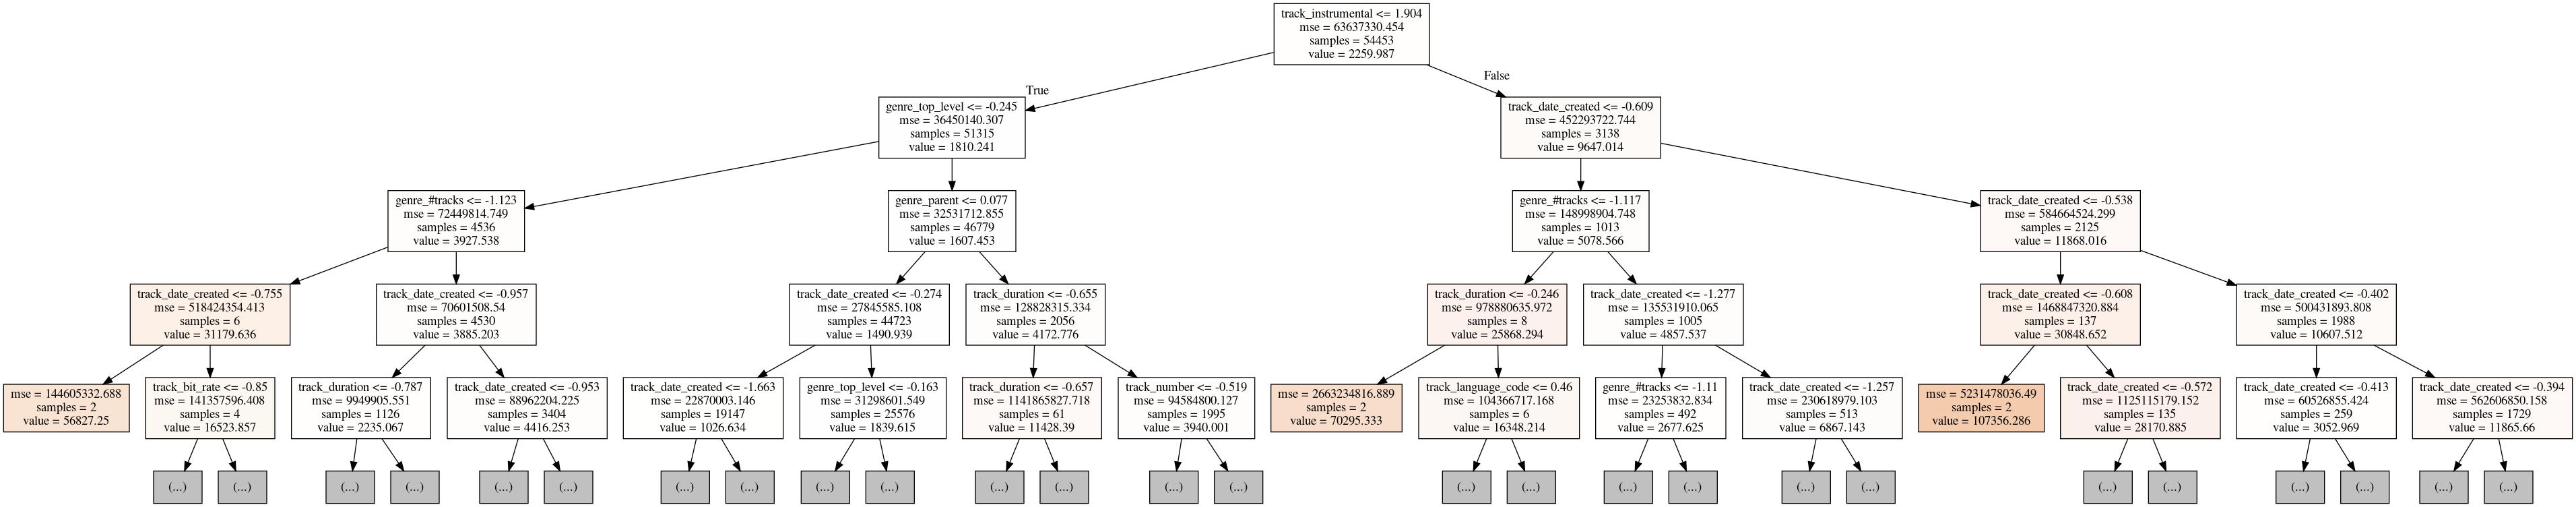

In [177]:
from IPython.display import Image
Image('tree.png')

In [74]:
!ls

__init__.py  notebook.ipynb  __pycache__  README.md


In [75]:
!ls ..

app.py		 notebooks    Procfile		run.py
assets		 notes.md     __pycache__	run.pyc
environment.yml  output.html  README.md		run_server.sh
LICENSE		 pages	      requirements.txt	util.py


In [87]:
tracks_df

track_id      album_id      artist_id  license_parent_id  \
count  101270.000000  101270.00000  101270.000000       77132.000000   
mean    78071.239785   12756.89686   11875.228133           5.244568   
std     44861.202612    6231.82772    6929.837526           1.282131   
min         2.000000       1.00000       1.000000           2.000000   
25%     39008.250000    7694.25000    6134.000000           5.000000   
50%     75677.500000   13244.00000   11789.000000           5.000000   
75%    118528.750000   18129.00000   17927.000000           6.000000   
max    155320.000000   22940.00000   24357.000000          10.000000   

       track_bit_rate  track_comments  track_date_created  \
count   101142.000000   101270.000000        1.012700e+05   
mean    264451.027753        0.030147        1.358592e+18   
std      66629.082193        0.312680        7.873561e+16   
min        192.000000        0.000000        1.227635e+18   
25%     194001.000000        0.000000        1.289404e+18   
50%     319103.500000        0.000000        1.357755e+18   
75%     320000.000000        0.000000        1.430191e+18   
max     448000.000000       37.000000        1.490887e+18   

       track_date_recorded  track_disc_number  track_duration  \
count         1.012700e+05      101270.000000   101270.000000   
mean         -8.595132e+18           1.009875      277.175511   
std           2.467413e+18           0.134652      336.112851   
min          -9.223372e+18           0.000000        0.000000   
25%          -9.223372e+18           1.000000      150.000000   
50%          -9.223372e+18           1.000000      217.000000   
75%          -9.223372e+18           1.000000      306.000000   
max           1.489450e+18           4.000000    18350.000000   

       track_favorites  track_instrumental  track_interest  track_listens  \
count    101270.000000       101270.000000    1.012700e+05  101270.000000   
mean          3.168619            0.057500    3.457505e+03    2265.997383   
std          13.657748            0.232796    1.880634e+04    7911.263888   
min           0.000000            0.000000    3.000000e+00       1.000000   
25%           0.000000            0.000000    5.970000e+02     292.000000   
50%           1.000000            0.000000    1.293000e+03     755.000000   
75%           3.000000            0.000000    3.006000e+03    1981.000000   
max        1482.000000            1.000000    3.293557e+06  543252.000000   

        track_number       genre_id  genre_#tracks   genre_parent  \
count  101270.000000  101270.000000  101270.000000  101270.000000   
mean        8.340111      45.155150   15472.733208      56.532142   
std        15.208858     103.973302   13751.533130     230.838854   
min         0.000000       1.000000       4.000000       0.000000   
25%         2.000000      12.000000    4162.000000       0.000000   
50%         5.000000      17.000000    8693.000000       0.000000   
75%         9.000000      38.000000   34413.000000      17.000000   
max       255.000000    1235.000000   38154.000000    1235.000000   

       genre_top_level  
count    101270.000000  
mean         68.612857  
std         242.055385  
min           2.000000  
25%          12.000000  
50%          15.000000  
75%          38.000000  
max        1235.000000

In [91]:
train[features].head()

track_bit_rate   track_date_created  track_date_recorded  \
57758        270889.0  1430190677000000000 -9223372036854775808   
5026         256000.0  1488690596000000000 -9223372036854775808   
38713        192000.0  1354827821000000000 -9223372036854775808   
46957        256000.0  1284180514000000000 -9223372036854775808   
51443        256000.0  1293181101000000000 -9223372036854775808   

       track_duration  track_instrumental track_language_code  track_number  \
57758              10                   0                  NA             0   
5026              315                   1                  NA             4   
38713             192                   0                  NA             2   
46957             135                   0                  NA            12   
51443             290                   0                  NA             6   

       genre_id album_type  genre_parent  genre_top_level  genre_#tracks  \
57758        10      Album             0               10          13845   
5026         15      Album             0               15          34413   
38713        27      Album            12               12           6041   
46957        32      Album            38               38           7268   
51443        33      Album            17               17           2267   

      track_explicit  track_listens  
57758             NA            424  
5026      Radio-Safe           1161  
38713             NA           3419  
46957             NA             89  
51443             NA             87

In [133]:
my_features = features.copy()
my_features.remove('track_date_recorded')
my_features.remove('track_date_created')
my_features = my_features + ['track_date_created_dt']

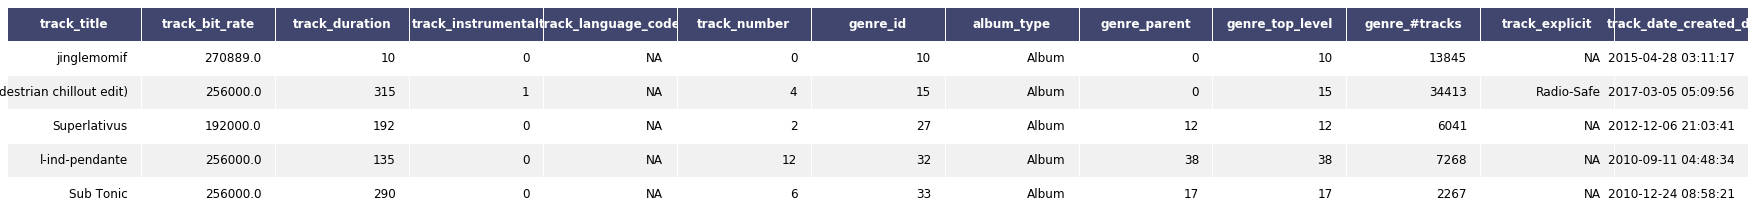

In [173]:
import six 

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1.5, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax


render_mpl_table(train[['track_title'] + my_features].head(), header_columns=0, col_width=1.6)

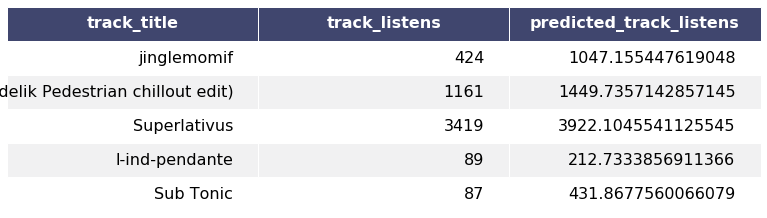

In [174]:
my_df = train[ ['track_title',target,'y_pred'] ].head().copy()
my_df = my_df.rename(columns={'y_pred' : 'predicted_track_listens'})
render_mpl_table( my_df, header_columns=0,col_width=3.0, font_size=16)

In [168]:
train[target].mean()

2269.779040184017